In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")

aux_target_ratio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

In [34]:
credit_dsa = {}
log_credit_dsa = {}

for split in [4,3,2]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=split, units=64, ed_act="relu")
    credit_dsa[split] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log_credit_dsa[split] = credit_dsa[split].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(),
        batch_size=32,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        verbose=True,
        log_freq=500)

======Split level is 4======
Iteration 500, train accuracy: 0.7902489334344864, average attack MSE: 0.13791647924482822
Iteration 1000, train accuracy: 0.8046108911037445, average attack MSE: 0.11325306521356106
Iteration 1500, train accuracy: 0.8083043259382248, average attack MSE: 0.08321783705055713
Iteration 2000, train accuracy: 0.811213280081749, average attack MSE: 0.05787115366756916
Iteration 2500, train accuracy: 0.8131789571046829, average attack MSE: 0.04332302346453071
Iteration 3000, train accuracy: 0.814170110821724, average attack MSE: 0.03530600376799703
Iteration 3500, train accuracy: 0.8145204846858978, average attack MSE: 0.0311499246545136
Iteration 4000, train accuracy: 0.8152458901405335, average attack MSE: 0.031051885697990656
Iteration 4500, train accuracy: 0.8156371966600419, average attack MSE: 0.03236610601097346
Iteration 5000, train accuracy: 0.8160195416212082, average attack MSE: 0.03162386893481016
Iteration 5500, train accuracy: 0.8165426244735717, av

In [35]:
from fsha import *

credit_fsha={}
log_credit_fsha={}

for split in [4,3,2]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    hparams = {
        'WGAN' : False,
        'style_loss' : None,
        'lr_f' :  0.001,
        'lr_tilde': 0.001,
        'lr_D': 0.001,
        'lr_g': 0.001
    }
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp_fsha(attr_num=23, class_num=2, split=split, units=64, ed_act=None)
    models = (make_f, make_g, make_e, make_d, make_c)
    credit_fsha[split] = FSHA(
        target_ds, aux_ds,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(), models=models, batch_size=32, hparams=hparams)
    log_credit_fsha[split]=credit_fsha[split](10000, verbose=True, progress_bar=False, log_frequency=1000)

======Split level is 4======
RUNNING...
Iteration 0000000 train accuracy: 0.6875, validation: 0.1461
Iteration 0001000 train accuracy: 0.7692, validation: 0.0753
Iteration 0002000 train accuracy: 0.7771, validation: 0.0922
Iteration 0003000 train accuracy: 0.7776, validation: 0.0616
Iteration 0004000 train accuracy: 0.7782, validation: 0.0380
Iteration 0005000 train accuracy: 0.7786, validation: 0.0264
Iteration 0006000 train accuracy: 0.7787, validation: 0.0228
Iteration 0007000 train accuracy: 0.7788, validation: 0.0212
Iteration 0008000 train accuracy: 0.7790, validation: 0.0212
Iteration 0009000 train accuracy: 0.7790, validation: 0.0214
======Split level is 3======
RUNNING...
Iteration 0000000 train accuracy: 0.7500, validation: 0.1441
Iteration 0001000 train accuracy: 0.7772, validation: 0.0912
Iteration 0002000 train accuracy: 0.7787, validation: 0.0805
Iteration 0003000 train accuracy: 0.7796, validation: 0.0608
Iteration 0004000 train accuracy: 0.7795, validation: 0.0390
Itera

In [ ]:
with open('log/credit-dsa.pkl', 'wb') as f:
    pickle.dump(log_credit_dsa, f)
with open('log/credit-fsha.pkl', 'wb') as f:
    pickle.dump(log_credit_fsha, f)

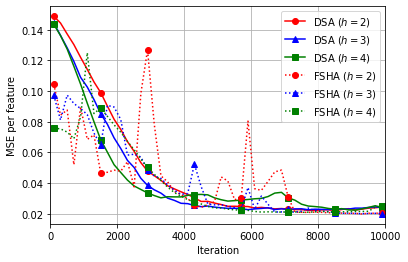

In [45]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_loss = {}
sampled_fsha_loss = {}

for split in [2,3,4]:
    sampled_loss[split] = [sum(log_credit_dsa[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa[split][:,0])/log_freq))]
    sampled_fsha_loss[split] = [sum(log_credit_fsha[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('MSE per feature')
plt.xlabel('Iteration')
plt.plot(ran, sampled_loss[2], 'ro-', ran, sampled_loss[3], 'b^-', ran, sampled_loss[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_loss[2], 'ro:', ran, sampled_fsha_loss[3], 'b^:', ran, sampled_fsha_loss[4], 'gs:', markevery=7)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
# plt.savefig("fig/credit.pdf", bbox_inches='tight')

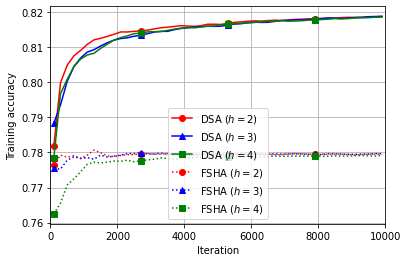

In [46]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_acc = {}
sampled_fsha_acc = {}

for split in [2,3,4]:
    sampled_acc[split] = [sum(log_credit_dsa[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_dsa[split][:,0])/log_freq))]
    sampled_fsha_acc[split] = [sum(log_credit_fsha[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_credit_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('Training accuracy')
plt.xlabel('Iteration')
plt.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=13)
plt.plot(ran, sampled_fsha_acc[2], 'ro:', ran, sampled_fsha_acc[3], 'b^:', ran, sampled_fsha_acc[4], 'gs:', markevery=13)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.ylabel('Training accuracy')
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
# plt.savefig("fig/credit-acc.pdf", bbox_inches='tight')

In [ ]:
split=4
credit_dsa_size = {}
log_credit_dsa_size = {}

make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=23, class_num=2, split=split, units=64, ed_act="relu")

for size in [1,5,10,20,50]:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=42)
    
    target_ds = make_dataset(x_train, y_train, lambda t: t)
    aux_ds = make_dataset(x_test, y_test, lambda t: t)
    
    credit_dsa_size[size] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Auxiliary size is {}======".format(size))
    print("============================")
    log_credit_dsa_size[size] = credit_dsa_size[size].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        acc_fn=tf.keras.metrics.BinaryAccuracy(),
        batch_size=32,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        verbose=True,
        log_freq=500)

======Auxiliary size is 1======
Iteration 500, train accuracy: 0.7782253197431565, average attack MSE: 0.153564020216465
Iteration 1000, train accuracy: 0.8027189645767212, average attack MSE: 0.14157731863856315
Iteration 1500, train accuracy: 0.8084302216768264, average attack MSE: 0.12582934133708476
Iteration 2000, train accuracy: 0.8104480456113815, average attack MSE: 0.1047651645988226
Iteration 2500, train accuracy: 0.8118945262432098, average attack MSE: 0.08296414223313332
Iteration 3000, train accuracy: 0.8131754456758499, average attack MSE: 0.06684052935987711
Iteration 3500, train accuracy: 0.8143604680299759, average attack MSE: 0.0566902030557394


Error: Canceled future for execute_request message before replies were done

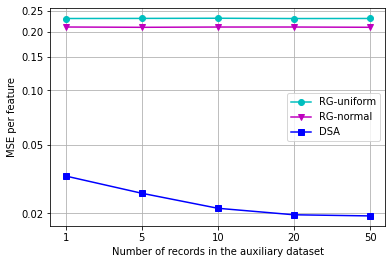

In [84]:
ran = ["1","5","10","20","50"]
rgn = [tf.keras.losses.MeanSquaredError()(np.random.normal(loc=0.5,scale=0.25,size=x.shape),x) for i in ran]
rgu = [tf.keras.losses.MeanSquaredError()(np.random.uniform(low=0,high=1,size=x.shape),x) for i in ran]
mse = [0.033,0.0262,0.0214,0.0196,0.0193]
plt.yscale('logit')
plt.grid()
plt.yticks(ticks=[0.02,0.05,0.1,0.15,0.2,0.25],labels=["0.02","0.05","0.10","0.15","0.20","0.25"])
plt.plot(ran,rgu,'co-',ran,rgn,'mv-',ran,mse,'bs-', markevery=1)
plt.ylabel('MSE per feature')
plt.xlabel('Number of records in the auxiliary dataset')
plt.legend(["RG-uniform", "RG-normal", "DSA"])
plt.savefig("fig/credit-size.pdf", bbox_inches='tight')